## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

from tqdm.notebook import tqdm

## Prepare dataset

In [3]:
from sklearn.model_selection import train_test_split

valid = [p.path for p in os.scandir('../input/shanghaitech/ShanghaiTech/part_B/test_data/images/')]

len(valid)

316

In [4]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
aug_val = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fn = self.files[idx]
        
        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
        ps = m['image_info'][0][0][0][0][0]
        
        rst = self.aug(image=im, keypoints=ps)
        im = rst['image']
        ps = rst['keypoints']
        
        dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
        for x, y in ps:
            x = int(x)
            y = int(y)
            dm[y, x] = 1

        sigma = 4
        dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
        
        dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
        dm *= 16
        
        im = torch.from_numpy(im)
        dm = torch.from_numpy(dm)
        
        return im, dm

## Building Model

In [6]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


In [7]:
class MCNN(LightningModule):
    '''
    Multi-column CNN 
        -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
    '''
    
    def __init__(self, lr, batch_size, max_steps, bn=False):
        super(MCNN, self).__init__()
        
        self.lr = lr
        self.save_hyperparameters()
        
        self.use = 0
        
        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))
        
        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))
        
        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))
        
        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
        
        self.out1 = nn.Sequential(Conv2d( 8, 1, 1, same_padding=True, bn=bn))
        self.out2 = nn.Sequential(Conv2d( 10, 1, 1, same_padding=True, bn=bn))
        self.out3 = nn.Sequential(Conv2d( 12, 1, 1, same_padding=True, bn=bn))
        
        self.crit = nn.MSELoss()
        
    def forward(self, im_data):
        im_data = im_data.unsqueeze(1)
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        
        
        if self.use == 0:
            x = torch.cat((x1,x2,x3),1)
            x = self.fuse(x)
        elif self.use == 1:
            x = self.out1(x1)
        elif self.use == 2:
            x = self.out2(x2)
        elif self.use == 3:
            x = self.out3(x3)
        
        return x.squeeze(1)

## Visualize the result
We can see that the recognition results highlight the human body

In [8]:
model = MCNN.load_from_checkpoint('../input/shtech-mcnn/lightning_logs/version_0/checkpoints/epoch=267-step=3215.ckpt')

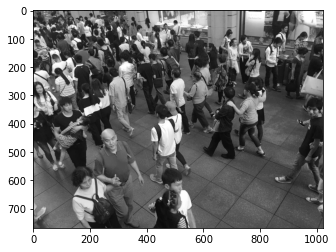

In [9]:
ds = MyDataset(valid, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

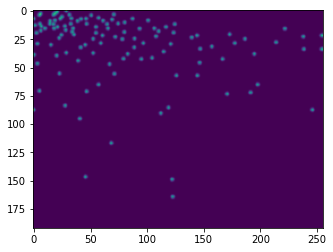

In [10]:
plt.imshow(dm)

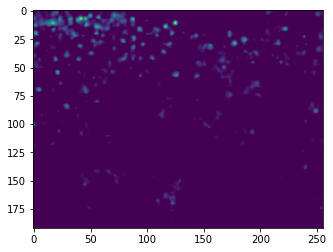

In [11]:
plt.imshow(model(im.unsqueeze(0)).detach()[0])

In [12]:
model(im.unsqueeze(0)).detach()[0].sum(), dm.sum()

(tensor(98.2053), tensor(117.))

## Eval

In [13]:
val_loader = DataLoader(MyDataset(valid, aug_val), batch_size=32, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

In [14]:
model = MCNN.load_from_checkpoint('../input/shtech-mcnn/lightning_logs/version_0/checkpoints/epoch=267-step=3215.ckpt')
model = model.cuda()
model.eval()
rst = []
gt = []
for x, y in tqdm(val_loader):
    with torch.no_grad():
        x = x.cuda(non_blocking=True)
        pred = torch.round(model(x).sum(dim=(1,2))).int().cpu().numpy()
        
    rst.append(pred)
    gt.append(y.sum(dim=(1,2)).int().numpy())
    
rst = np.concatenate(rst, axis=0)
gt = np.concatenate(gt, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

### MAE

In [15]:
np.abs((rst - gt)).astype(np.float32).mean()

24.142405

### MSE

In [16]:
((rst - gt) ** 2).mean()

1835.009493670886